In [1]:
print("hello")

hello


In [2]:
import numpy as np
import jax.numpy as jnp
import re
import cupy as cp
import pickle
import time
import numpy as np
import jax.numpy as jnp
import pandas as pd
import numpy as np
import jax
import spacy
from tqdm import tqdm
from pathlib import Path
import json

np.set_printoptions(edgeitems=30, linewidth=100000, formatter=dict(float=lambda x: "%.3g" % x))


def log_time(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()  # Record start time
        result = func(*args, **kwargs)  # Execute the wrapped function
        end_time = time.time()  # Record end time
        elapsed_time = end_time - start_time
        # print(f"Function '{func.__name__}' executed in {elapsed_time:.4f} seconds")
        return result

    return wrapper


def get_positional_encoding(seq_len, d_model):
    """
    Returns a non-learnable (sinusoidal) positional encoding.


    seq_len: Length of the input sequence.
    d_model: Dimension of the embeddings.
    """
    pos = cp.arange(seq_len)[:, cp.newaxis]  # Shape: [seq_len, 1]
    i = cp.arange(d_model)[cp.newaxis, :]  # Shape: [1, d_model]

    angle_rates = 1 / cp.power(10000, (2 * (i // 2)) / cp.float32(d_model))

    # Apply sine to even indices, cosine to odd indices
    pos_encoding = cp.zeros((seq_len, d_model))
    pos_encoding[:, 0::2] = cp.sin(pos * angle_rates[:, 0::2])  # sine on even indices
    pos_encoding[:, 1::2] = cp.cos(pos * angle_rates[:, 1::2])  # cosine on odd indices

    return pos_encoding


def softmax(x, axis=-1):
    # Subtract the max value for numerical stability
    e_x = cp.exp(x - cp.max(x, axis=axis, keepdims=True))
    return e_x / cp.sum(e_x, axis=axis, keepdims=True)


def layer_norm(x, epsilon=1e-6):
    # Calculate the mean and variance
    mean = cp.mean(x, axis=-1, keepdims=True)
    var = cp.var(x, axis=-1, keepdims=True)

    # Normalize the output
    x_norm = (x - mean) / cp.sqrt(var + epsilon)
    # print(x)
    # print(mean)
    # print("mean",mean.shape)
    # print("x_norm.shape",x_norm.shape)
    return x_norm, mean, var, x.shape[-1]


def relu(x):
    return cp.maximum(0, x)


# @log_time
def pad_sequence(seq, max_len, pad_value=0):
    """Pad a sequence with a given value up to max_len."""
    current_len = seq.shape[0]
    pad_width = max_len - current_len
    if pad_width > 0:
        # Pad sequence with zeros (or any pad_value you provide)
        seq = cp.pad(seq, ((0, pad_width), (0, 0)), mode='constant', constant_values=pad_value)
    return seq


@log_time
def create_timestaped_input(input_d, words_per_phrase):
    input_translation = []
    for j in range(input_d.shape[0]):
        # Create padded sequences
        padded_sequences = [pad_sequence(input_d[j][0:i], words_per_phrase) for i in range(1, input_d.shape[1] + 1)]
        input_translation.append(padded_sequences)
    return cp.array(input_translation)


def cross_entropy_loss(predictions, target):
    # Cross-entropy loss for a batch of predictions and targets
    batch_loss = -cp.sum(target * cp.log(predictions + 1e-9), axis=1)
    return cp.mean(batch_loss)


def diff_norm(X, var, mu, N):
    epsilon = 1e-6
    AA = ((1 - (1 / N)) * (1 / (cp.sqrt(var + epsilon))))
    BB = (1 / N) * ((X - mu) ** 2)
    CC = ((var + epsilon) ** (3 / 2))
    result = (AA - (BB / CC))
    return result


def redimension(X):
    return cp.concatenate(cp.swapaxes(X, 0, 1), axis=-1)


def diffQKV(dAttention, Attention_weights, X1, X2, X3, dk, matrix=""):
    global num_heads
    # print("----------------")
    # print("dAcr.shape",dAttention.shape)
    dAttention_weights = Attention_weights * (1 - Attention_weights)
    # print("dW.shape",dAttention_weights.shape)
    # print("QC.shape",X1.shape)
    # print("VC.shape",X2.shape)
    # print("Ecout.shape",X3.shape)

    if matrix != "k":
        dLoss_dX = cp.transpose(dAttention, (0, 2, 1)) @ (
                    redimension(dAttention_weights @ (X1 * X2) / cp.sqrt(dk)) * X3)
    else:
        #  print("X1@cp.transpose(X2,(0,2,1))",(dAttention_weights*(X1@cp.transpose(X2,(0,1,3,2)))).shape)
        #  print(X3[0].shape)
        ################################ check X3
        X3 = cp.swapaxes(cp.array(cp.array_split(X3, num_heads, axis=2)), 0, 1)
        #  print(X3[0].shape)
        dLoss_dX = cp.transpose(dAttention, (0, 2, 1)) @ redimension(
            (dAttention_weights * (X1 @ cp.transpose(X2, (0, 1, 3, 2))) @ X3) / cp.sqrt(dk))
    # print("dLoss_dX.shape",dLoss_dX.shape)

    # V1=dAttention_weights@X1/cp.sqrt(dk)
    # print("V1 shape",V1.shape)
    # V2=cp.transpose(X2,(0,1,3,2))
    # print("V2 shape",V2.shape)
    # print("(V1@V2)",(V1@V2).shape)
    # V3=redimension(V1@V2)*X3

    # V3=V1@cp.transpose(V2,(0,2,1))*X3

    return dLoss_dX


@log_time
def create_vocabulary(complete_text, name, nlp):
    # Use re.findall to split considering punctuation
    text = re.findall(r'\[.*?\]|\w+|[^\w\s]|\n', complete_text)

    words_list = list(set(text))

    vocabulary = dict()

    for i, j in enumerate(words_list):
        # vocabulary[j]=(jax.random.uniform(jax.random.key(cp.random.randint(10000)),embedding_size),i)
        vocabulary[j] = (cp.array(nlp(j).vector), i)
        # print(j,len(cp.array(nlp(j).vector)))

    # print(vocabulary)
    # print("Vocabulary size: ", len(vocabulary))
#     with open(f"data/{name}.pkl", 'wb') as handle:
#         pickle.dump(vocabulary, handle, protocol=pickle.HIGHEST_PROTOCOL)

    return vocabulary


@log_time
def pad_sequences(sentences, lenght, pad_token='[PAD]', target_type=None):
    """
    Pads the input sentences to have the same length by adding [PAD] tokens at the end.
    """

    if target_type == "encoder":
        # Split each sentence into words
        tokenized_sentences = [["[START]"] + re.findall(r'\[.*?\]|\w+|[^\w\s]\n', sentence) + ["[END]"] for sentence in
                               sentences]
    elif target_type == "decoder":
        tokenized_sentences = [["[START]"] + re.findall(r'\[.*?\]|\w+|[^\w\s]|\n', sentence) for sentence in sentences]
    elif target_type == "target":
        tokenized_sentences = [re.findall(r'\[.*?\]|\w+|[^\w\s]|\n', sentence) + ["[END]"] for sentence in sentences]
    # print(tokenized_sentences)
    if lenght == 0:
        # Find the maximum sentence length
        max_len = max(len(sentence) for sentence in tokenized_sentences)
    else:
        max_len = lenght

    # Pad each sentence with the [PAD] token to make them of equal length
    padded_sentences = [" ".join(sentence + [pad_token] * (max_len - len(sentence))) for sentence in
                        tokenized_sentences]

    return padded_sentences


@log_time
def generate_input_encoder(x_batch, vocabulary_encoder, max_words_per_phrase):
    x_train = pad_sequences(x_batch, max_words_per_phrase, target_type="encoder")

    xi = []
    # print(x_batch)
    phrase_vectors_x = [re.findall(r'\[.*?\]|\w+|[^\w\s]|\n', x) for x in x_train]

    phrase_vectors_x = [i[0:max_words_per_phrase] for i in phrase_vectors_x]

    # print(phrase_vectors_x)
    # a=cp.array(phrase_vectors_x).shape

    # print("a",a)
    # print("len phrases:\n",[len(i) for i in phrase_vectors_x])

    xi = cp.array([[vocabulary_encoder[word][0] for word in phrase_vector] for phrase_vector in phrase_vectors_x])

    return xi


# @log_time
def update_wembedding_encoder(x_batch, inputs_e, vocabulary, max_words_per_phrase):
    x_train = pad_sequences(x_batch, max_words_per_phrase, target_type="encoder")
    # print(x_train)

    phrase_vectors_x = [re.findall(r'\[.*?\]|\w+|[^\w\s]|\n', x) for x in x_train]

    phrase_vectors_x = [i[0:max_words_per_phrase] for i in phrase_vectors_x]
    # print("inputs_e",inputs_e.shape)
    # print("(phrase_vectors_x).shape:\n",cp.array(phrase_vectors_x).shape)

    for phrase in range(inputs_e.shape[0]):
        # print(phrase)
        for position, word in enumerate(phrase_vectors_x[phrase]):
            #   print("word",word)
            #   print("original values",vocabulary[word][0])
            #   print("updated  values",inputs_e[phrase][position])
            #   print("index",vocabulary[word][1])
            vocabulary[word] = (inputs_e[phrase][position], vocabulary[word][1])

    return vocabulary


# @log_time
def update_wembedding_decoder(y_batch, inputs_decoder, max_words_per_phrase, vocabulary):
    # print("inputs_decoder",inputs_decoder.shape)
    decoder_input = pad_sequences(y_batch, lenght=max_words_per_phrase, target_type="decoder")
    decoder_input = [i.split() for i in decoder_input]
    # print(max_words_per_phrase)
    if max_words_per_phrase == None:
        max_words_per_phrase = len(decoder_input[0])

    phrase_vectors_y = [i[0:max_words_per_phrase] for i in decoder_input]
    # for sentence in phrase_vectors_y:
    #     print(sentence)
    for phrase in range(inputs_decoder.shape[0]):
        # print(phrase)
        for position, word in enumerate(phrase_vectors_y[phrase]):
            # print("word",word)
            # print("original values",vocabulary[word][0])
            # print("updated  values",inputs_decoder[phrase][position])
            #  print("delta input",cp.sum(vocabulary[word][0]-inputs_decoder[phrase][position]))
            # print("index",vocabulary[word][1])
            vocabulary[word] = (inputs_decoder[phrase][position], vocabulary[word][1])

    return vocabulary


@log_time
def create_input_encoder(X, vocabulary_encoder, max_words_per_phrase, embedding_size):
    pos_encoding = get_positional_encoding(max_words_per_phrase, embedding_size)
    inputs_e = generate_input_encoder(X, vocabulary_encoder, max_words_per_phrase)
    inputs_e += pos_encoding
    return inputs_e


@log_time
def create_decoder_input(y_train, embedding_size, max_words_per_phrase, vocabulary_decoder):
    decoder_input = pad_sequences(y_train, lenght=max_words_per_phrase, target_type="decoder")
    decoder_input = [i.split() for i in decoder_input]
    # print(max_words_per_phrase)
    if max_words_per_phrase == None:
        max_words_per_phrase = len(decoder_input[0])

    phrase_vectors_y = [i[0:max_words_per_phrase] for i in decoder_input]
    # for sentence in phrase_vectors_y:
    #     print(sentence)
    yi = cp.array([[vocabulary_decoder[word][0] for word in phrase_vector] for phrase_vector in phrase_vectors_y])
    pos_encoding = get_positional_encoding(max_words_per_phrase, embedding_size)
    # print(pos_encoding.shape,yi.shape)
    yi = yi + pos_encoding

    decoder_inputs = cp.array(cp.swapaxes(create_timestaped_input(yi, max_words_per_phrase), 0, 1))

    # decoder_inputs[zero_rows] = vocabulary_decoder["[PAD]"][0]
    for i in range(decoder_inputs.shape[0]):
        for j in range(decoder_inputs[i].shape[0]):
            zero_rows = cp.all(decoder_inputs[i][j] == 0, axis=1)

            decoder_inputs[i][j][zero_rows] = vocabulary_decoder["[PAD]"][0]

    decoder_inputs = cp.array(decoder_inputs)
    return decoder_inputs


# @log_time
def get_one_hot(word, vocabulary_decoder):
    # print(word)
    vocab_size = len(vocabulary_decoder)
    one_hot_vector = cp.zeros(vocab_size)
    one_hot_vector[vocabulary_decoder[word][1]] = 1
    return one_hot_vector


@log_time
def create_target(y_train, max_words_per_phrase, vocabulary):
    target_d = pad_sequences(y_train, lenght=max_words_per_phrase, target_type="target")
    target_d = [i.split() for i in target_d]
    target_d = [[get_one_hot(word, vocabulary) for word in phrase] for phrase in target_d]
    # print([len(i) for i in target_d])
    target_d = cp.swapaxes(create_timestaped_input(cp.array(target_d), max_words_per_phrase), 0, 1)
    targets_d = []

    for i in range(target_d.shape[0]):
        ff = []
        # print(i,target_d[i].shape)
        for j in range(target_d[i].shape[0]):
            ff.append(target_d[i][j][i])
            # print(targets_d[i][j][i])
        targets_d.append(ff)
        # print(ff)
    targets_d = cp.array(targets_d)
    return targets_d


def bucket_by_length(x_train, y_train, batch_size):
    # Pair x_train and y_train together
    paired_data = list(zip(x_train, y_train))

    # Sort the pairs by the length of the x_train phrases
    paired_data_sorted = sorted(paired_data, key=lambda pair: len(pair[1]))

    # Initialize buckets for x_train and y_train
    x_batches = []
    y_batches = []

    # Group phrases into batches of batch_size
    for i in range(0, len(paired_data_sorted), batch_size):
        batch = paired_data_sorted[i:i + batch_size]

        # Split the batch back into x_train and y_train
        x_batch, y_batch = zip(*batch)

        x_batches.append(list(x_batch))
        y_batches.append(list(y_batch))

    return x_batches, y_batches


def pad_inputs(sentences, target_type):
    if target_type == "encoder":
        tokenized_sentences = [['[START]'] + sentence + ['[END]'] for sentence in sentences]
    elif target_type == "decoder":
        tokenized_sentences = [["[START]"] + sentence for sentence in sentences]
    elif target_type == "target":
        tokenized_sentences = [sentence + ["[END]"] for sentence in sentences]
    return tokenized_sentences


def generate_inputs(sentences, vocabulary, pad_token='[PAD]', target_type=None):
    """
    Pads the input sentences to have the same length by adding [PAD] tokens at the end.
    """

    tokenized_sentences = pad_inputs(sentences, target_type)
    max_len = max(len(sentence) for sentence in tokenized_sentences)
    # Pad each sentence with the [PAD] token to make them of equal length
    padded_sentences = [sentence + [pad_token] * (max_len - len(sentence)) for sentence in tokenized_sentences]

    # print(padded_sentences)
    xi = cp.array([[vocabulary[word][0] for word in phrase_vector] for phrase_vector in padded_sentences])
    # print(xi.shape)
    pos_encoding = get_positional_encoding(max_len, 300)
    xi += pos_encoding

    if target_type == "decoder":
        xi = cp.array(cp.swapaxes(create_timestaped_input(xi, max_len), 0, 1))

    return xi


def forward_attention_encoder(inputs_e):
    global Qe, Ke, Ve, num_heads, batch_size, dk

    Q_E = cp.swapaxes(cp.array(cp.array_split(cp.matmul(inputs_e, Qe), num_heads, axis=2)), 0, 1)
    # print("Qval.shape: ",Q_E.shape)

    K_E = cp.swapaxes(cp.array(cp.array_split(cp.matmul(inputs_e, Ke), num_heads, axis=2)), 0, 1)
    # print("Kval.shape: ",K_E.shape)

    V_E = cp.swapaxes(cp.array(cp.array_split(cp.matmul(inputs_e, Ve), num_heads, axis=2)), 0, 1)
    # print("Vval.shape: ",V_E.shape)

    QKscaled = cp.matmul(Q_E, cp.transpose(K_E, (0, 1, 3, 2))) / cp.sqrt(dk)

    Attention_weights_e = softmax(QKscaled)
    # print("Attention_weights shape:",Attention_weights_e.shape)

    Ae = cp.matmul(Attention_weights_e, V_E)
    # print("Attention shape:",Ae.shape)

    Ae = cp.array([cp.concatenate(Ae[i], axis=1) for i in range(batch_size)])
    # print("Attention encoder shape concat:",Ae.shape)

    return Ae, Attention_weights_e, K_E, V_E, Q_E


def encoder_first_residual_and_norm(Ae, inputs_e):
    Xe = Ae + inputs_e
    Ect1, mu_e, var_e, Ne = layer_norm(Xe)
    # print("Ect1.shape",Ect1.shape,Ne)
    return Ect1, Xe, mu_e, var_e, Ne


def fully_connected_layers_encoder(Ect1):
    global Wfl1e, bfl1e, Wfl2e, bfl2e

    Xe1 = cp.matmul(Ect1, Wfl1e) + bfl1e
    FLe1 = relu(Xe1)

    FLe2 = cp.matmul(FLe1, Wfl2e) + bfl2e

    Xe2 = FLe2 + Ect1
    Ecout, mu_e2, var_e2, N_e2 = layer_norm(Xe2)
    # print("Ecout.shape",Ecout.shape)
    return Ecout, mu_e2, var_e2, N_e2, FLe1, Xe1, Xe2


def cross_attention_encoder(Ecout):
    global Kc, Vc
    K_C = cp.swapaxes(cp.array(cp.array_split(cp.matmul(Ecout, Kc), num_heads, axis=2)), 0, 1)
    # print("K_C.shape: ",K_C.shape)# shape is: num_phrases, numbheads, words_per_phrase, dv/num_heads
    V_C = cp.swapaxes(cp.array(cp.array_split(cp.matmul(Ecout, Vc), num_heads, axis=2)), 0, 1)
    # print("V_C.shape: ",V_C.shape)
    return K_C, V_C


########################################################DECODER
def forward_attention_decoder(input_decoder):
    global Qd, Kd, Vd  # ,words_per_phrase

    Q_D = cp.swapaxes(cp.array(cp.array_split(cp.matmul(input_decoder, Qd), num_heads, axis=2)), 0, 1)
    # print("Qval.shape: ",Q_D.shape)# numwords, num_phrases, numheads, num_words, dv/num_heads

    # K_D  = cp.swapaxes(cp.swapaxes(cp.array(cp.array_split(cp.matmul(inputs_d[step], Kd),num_heads,axis=3)), 0, 1),1,2)
    K_D = cp.swapaxes(cp.array(cp.array_split(cp.matmul(input_decoder, Kd), num_heads, axis=2)), 0, 1)
    # print("Kval.shape: ",K_D.shape)

    # V_D  = cp.swapaxes(cp.swapaxes(cp.array(cp.array_split(cp.matmul(inputs_d[step], Vd),num_heads,axis=3)), 0, 1),1,2)
    V_D = cp.swapaxes(cp.array(cp.array_split(cp.matmul(input_decoder, Vd), num_heads, axis=2)), 0, 1)

    QKscaled_decoder = cp.matmul(Q_D, cp.transpose(K_D, (0, 1, 3, 2))) / cp.sqrt(dv)
    # Step 1: Create a causal mask of shape (1, 1, 9, 9) to broadcast across heads and batch
    mask_size = input_decoder.shape[1]  # words_per_phrase
    # print(mask_size)
    mask = cp.tril(cp.ones((mask_size, mask_size)))  # (9, 9) lower triangular matrix
    mask[mask == 0]=-cp.inf  # Set future tokens to -inf
    mask[mask == 1]=0 # Set allowed tokens to 0
    mask = mask.reshape(1, 1, mask_size, mask_size)

    # Step 2: Apply mask to QKscaled_decoder (it will broadcast across batch and heads)
    QKscaled_decoder = QKscaled_decoder + mask

    Attention_weights_masked = softmax(QKscaled_decoder)

    A_mask = cp.matmul(Attention_weights_masked, V_D)
    # print("A_mask.shape non concat: ",A_mask.shape)

    # A_mask=cp.swapaxes(cp.concatenate(cp.swapaxes(A_mask,0,2),axis=-1),0,1)
    A_mask = cp.concatenate(cp.swapaxes(A_mask, 0, 1), axis=-1)

    # print("A_mask.shape concat: ",A_mask.shape)
    # print("inputs_d.shape: ",input_decoder.shape)
    # print("Dt1.shape: ",Dt1.shape)
    return A_mask, Attention_weights_masked, Q_D, K_D, V_D


def decoder_first_residual_and_norm(A_mask, input_decoder):
    Xd = input_decoder + A_mask
    Dt1, mu_d, var_d, N_d = layer_norm(Xd)
    return Xd, Dt1, mu_d, var_d, N_d


def cross_attention_decoder(Dt1):
    global Qc
    Q_C = cp.swapaxes(cp.array(cp.array_split(cp.matmul(Dt1, Qc), num_heads, axis=2)), 0, 1)
    # print("Q_C.shape: ",Q_C.shape)
    return Q_C


def cross_attention(Q_C, K_C, V_C, Dt1):
    global dv
    # print("Q_C.shape",Q_C.shape)
    # print("K_C.shape",K_C.shape)
    # print("V_C.shape",V_C.shape)
    QKscaled_cross_attention = cp.matmul(Q_C, cp.transpose(K_C, (0, 1, 3, 2))) / cp.sqrt(dv)
    Attention_weights_cross = softmax(QKscaled_cross_attention)
    Acr = cp.matmul(Attention_weights_cross, V_C)
    # print("Acr.shape non concat",Acr.shape)
    Acr = cp.concatenate(cp.swapaxes(Acr, 0, 1), axis=-1)
    # print("Acr.shape concat",Acr.shape)

    return Acr, Attention_weights_cross


def cross_attention_residual_and_norm(Acr, Dt1):
    Res = Acr + Dt1
    Dt2, mu_res, var_res, N_res = layer_norm(Res)
    return Dt2, mu_res, var_res, N_res, Res


def fully_connected_layers_decoder(Dt2):
    global Wfl1d, bfl1d, Wfl2d, bfl2d, num_phrases

    Xd1 = cp.matmul(Dt2, Wfl1d) + bfl1d

    FLd1 = relu(Xd1)

    FLd2 = cp.matmul(FLd1, Wfl2d) + bfl2d
    # print("FLd2.shape",FLd2.shape)

    Xd2 = FLd2 + Dt2
    Dout, mu_d2, var_d2, N_d2 = layer_norm(Xd2)

    # print("Dout.shape",Dout.shape)
    Dout = Dout.reshape(Dout.shape[0], Dout.shape[1] * Dout.shape[2])
    # print("Dout.shape",Dout.shape)
    return Dout, mu_d2, var_d2, N_d2, Xd2, Xd1, FLd1


def output_layer(Dout):
    global Wo, bo

    Zout = cp.matmul(Dout, Wo) + bo

    SigmaZout = softmax(Zout)
    # print("SigmaZout.shape",SigmaZout.shape)

    return SigmaZout


def loss_calculation(SigmaZout, target):
    # print("target.shape",cp.array(target).shape)
    Loss = cross_entropy_loss(SigmaZout, target)
    # print("Loss:",Loss)
    return Loss


##################################################################BACKPROPAGATION
def derivate_dout(SigmaZout, target, Dout):
    global Wo, embedding_size, batch_size, words_per_phrase
    dLoss_dZout = SigmaZout - target
    # print("dLoss_dZout.shape",dLoss_dZout.shape)
    dLoss_W0 = cp.transpose(dLoss_dZout, (1, 0)) @ Dout
    # print("dLoss_W0.shape",dLoss_W0.shape,"W0.shape",W0.shape)
    dLoss_b0 = cp.sum(dLoss_dZout, axis=0)
    # print("dLoss_b0.shape",dLoss_b0.shape,"b0.shape",b0.shape)
    dLoss_Dout = dLoss_dZout @ Wo.T
    dLoss_Dout = dLoss_Dout.reshape(batch_size, words_per_phrase, embedding_size)
    # print("dLoss_Dout.shape",dLoss_Dout.shape)
    return dLoss_dZout, dLoss_Dout, dLoss_W0, dLoss_b0


def relu_backward(dA, Xd1):
    # Create mask where Xd1 > 0
    relu_mask = (Xd1 > 0).astype(float)  # This will give 1 where Xd1 > 0, else 0
    # Multiply the incoming gradient dA by the mask
    dXd1 = dA * relu_mask
    return dXd1


def derivate_fully_connected_layers_decoder(dLoss_Dout, Dt2, Xd2, var_d2, mu_d2, N_d2, FLd1, Xd1):
    global Wfl1d, Wfl2d

    dLoss_FLd2 = dLoss_Dout * diff_norm(Xd2, var_d2, mu_d2, N_d2)
    # print("dLoss_FLd2.shape",dLoss_FLd2.shape)
    dLoss_Dt2_a = dLoss_FLd2
    # print("dLoss_Dt2_a.shape",dLoss_Dt2_a.shape)
    # print("Dt2.shape",Dt2.shape)
    dLoss_FLd1 = dLoss_FLd2 @ cp.transpose(Wfl2d, (1, 0))
    # print("dLoss_FLd1.shape",dLoss_FLd1.shape)
    # print("FLd1.shape",FLd1.shape)
    dLoss_Wfl2d = cp.sum(cp.transpose(dLoss_FLd2, (0, 2, 1)) @ FLd1, axis=0).T
    # print("dLoss_Wfl2d.shape",dLoss_Wfl2d.shape) # do the mean here over each phrase
    # print("Wfl2d.shape",Wfl2d.shape)
    dLoss_bfl2d = cp.sum(cp.sum(dLoss_FLd2, axis=0), axis=0)
    # print("dLoss_bfl2d.shape",dLoss_bfl2d.shape) # do the mean here over each phrase
    # print("bfl2d.shape",bfl2d.shape)

    DLoss_Dt2_b = relu_backward(dLoss_FLd1, Xd1) @ cp.transpose(Wfl1d, (1, 0))
    DLoss_Dt2 = dLoss_Dt2_a + DLoss_Dt2_b
    # print("DLoss_Dt2.shape",DLoss_Dt2.shape) # do the mean here over each phrase
    # print("Dt2.shape",Dt2.shape)

    dLoss_Wfl1d = cp.sum(cp.transpose(relu_backward(dLoss_FLd1, Xd1), (0, 2, 1)) @ Dt2, axis=0).T
    # print("dLoss_Wfl1d.shape",dLoss_Wfl1d.shape) # do the mean here over each phrase
    # print("Wfl1d.shape",Wfl1d.shape)

    dLoss_bfl1d = cp.sum(cp.sum(relu_backward(dLoss_FLd1, Xd1), axis=0), axis=0)

    return dLoss_Wfl2d, dLoss_bfl2d, dLoss_Wfl1d, dLoss_bfl1d, DLoss_Dt2


def derivative_cross_attention(dLoss_Dt2, Res, var_res, mu_res, N_res, Attention_weights_cross, K_C, V_C, Q_C, Ecout,
                               Dt1):
    # print("dLoss_bfl1d.shape",dLoss_bfl1d.shape) # do the mean here over each phrase
    # print("bfl1d.shape",bfl1d.shape)
    global dk

    dLoss_Acr = dLoss_Dt2 * diff_norm(Res, var_res, mu_res, N_res)
    # print("dLoss_Acr.shape",dLoss_Acr.shape) # do the mean here over each phrase
    # print("Acr.shape",Acr.shape)
    dLoss_Dt1_a = dLoss_Dt2 * diff_norm(Res, var_res, mu_res, N_res)
    # print("dLoss_Dt1.shape-------",dLoss_Dt1_a.shape) # do the mean here over each phrase
    # print("Dt1.shape",Dt1.shape)

    dLoss_Qc = diffQKV(dLoss_Acr, Attention_weights_cross, K_C, V_C, Dt1, dk)
    # print("dLoss_dQc.shape",dLoss_Qc.shape) # do the mean here over each phrase
    # print("Qc.shape",Qc.shape)
    dLoss_Kc = diffQKV(dLoss_Acr, Attention_weights_cross, Q_C, V_C, Ecout, dk, matrix="k")
    # print("dLoss_dKc.shape",dLoss_Kc.shape) # do the mean here over each phrase
    # print("Kc.shape",Kc.shape)
    dLoss_Vc = cp.sum(cp.sum(cp.transpose(cp.expand_dims(dLoss_Acr, axis=1), (0, 1, 3, 2)) @ (
                Attention_weights_cross @ cp.expand_dims(Ecout, axis=1)), axis=1), axis=0)
    # print("dLoss_dVc.shape",dLoss_Vc.shape) # do the mean here over each phrase
    # print("Vc.shape",Vc.shape)
    return dLoss_Qc, dLoss_Kc, dLoss_Vc, Attention_weights_cross, dLoss_Dt1_a, dLoss_Acr


def derivative_attention_decoder(dLoss_Acr, Attention_weights_cross, dLoss_Dt1_a, Attention_weights_masked, Q_D, V_D,
                                 K_D, K_C, V_C, Xd, var_d, mu_d, N_d, input_d):
    global Qc, dk

    dAttention_weights_cross = Attention_weights_cross * (1 - Attention_weights_cross)
    # print("dAttention_weights_cross.shape",dAttention_weights_cross.shape)
    # V1=redimension(dAttention_weights_cross@K_C/cp.sqrt(dk))
    # print("K_C.shape",K_C.shape)
    # V2=redimension(V_C)
    # print("V_C.shape",V_C.shape)
    # print("Qc.shape",Qc.shape)

    # print("dLoss_Dt1_b.shape",dLoss_Dt1_a.shape)
    # V3=V1*V2@Qc
    # dLoss_Dt1_b=dLoss_Acr*V3
    # V3=V1@cp.transpose(V2@Qc,(0,2,1))
    # dLoss_Dt1_b=cp.transpose(dLoss_Acr,(0,2,1))@V3

    V1 = dAttention_weights_cross
    V2 = K_C * V_C / cp.sqrt(dk)
    V3 = redimension(V1 @ V2) @ Qc

    # print("V3.shape",dLoss_Dt1_a.shape)
    # print("dLoss_Acr.shape",dLoss_Acr.shape)
    dLoss_Dt1_b = dLoss_Acr * V3

    dLoss_Dt1 = dLoss_Dt1_a + dLoss_Dt1_b

    dLoss_Amask = dLoss_Dt1 * diff_norm(Xd, var_d, mu_d, N_d)
    # print("dLoss_DAmask.shape",dLoss_Amask.shape)
    dLoss_inputd_a = dLoss_Amask
    # print("dLoss_Dinputd_a.shape",dLoss_inputd_a.shape)
    dLoss_Kd = diffQKV(dLoss_Amask, Attention_weights_masked, Q_D, V_D, input_d, dk)
    # print("dLoss_Kd.shape",dLoss_Kd.shape)
    dLoss_Qd = diffQKV(dLoss_Amask, Attention_weights_masked, K_D, V_D, input_d, dk)
    # print("dLoss_Qd.shape",dLoss_Qd.shape)
    dLoss_Vd = cp.sum(cp.sum(cp.transpose(cp.expand_dims(dLoss_Amask, axis=1), (0, 1, 3, 2)) @ (
                Attention_weights_masked @ cp.expand_dims(input_d, axis=1)), axis=1), axis=0)
    return dLoss_Kd, dLoss_Qd, dLoss_Vd, dLoss_inputd_a, dLoss_Amask


def derivative_input_decoder(dLoss_Amask, Attention_weights_masked, K_D, V_D, Q_D, dLoss_inputd_a, input_d):
    global Qd, Kd, Vd, dk
    dLoss_V_D = cp.transpose(
        cp.sum(cp.transpose(cp.expand_dims(dLoss_Amask, axis=1), (0, 1, 3, 2)) @ Attention_weights_masked, axis=1),
        (0, 2, 1))
    dLoss_V_D.shape
    dLoss_inputd_v = dLoss_V_D @ Vd

    # print("dLoss_inputd_v.shape",dLoss_inputd_v.shape) # do the mean here over each phrase
    # print("input_d.shape",input_d.shape)

    dAttention_weights_masked = Attention_weights_masked * (1 - Attention_weights_masked)
    V1 = redimension(dAttention_weights_masked @ K_D / cp.sqrt(dk))
    V2 = redimension(V_D)
    V3 = V1 * V2
    dLoss_Q_D = dLoss_Amask * V3

    dLoss_inputd_q = dLoss_Q_D @ Qd
    # print("dLoss_inputd_q.shape",dLoss_inputd_q.shape)

    V1 = redimension(dAttention_weights_masked @ Q_D / cp.sqrt(dk))
    V2 = redimension(V_D)
    V3 = V1 * V2
    dLoss_K_D = dLoss_Amask * V3
    dLoss_inputd_k = dLoss_K_D @ Kd
    # print("dLoss_inputd_k.shape",dLoss_inputd_k.shape)
    dLoss_inputd = dLoss_inputd_a + dLoss_inputd_k + dLoss_inputd_q + dLoss_inputd_v

    dLoss_dWemb_decoder = dLoss_inputd * input_d

    return dLoss_inputd, dLoss_dWemb_decoder


def derivative_Ecout(Attention_weights_cross, dLoss_Acr, Q_C, V_C):
    global Kc, Vc, num_heads

    dAttention_weights_cross = Attention_weights_cross * (1 - Attention_weights_cross)
    # dLoss_Acr=cp.expand_dims(dLoss_Acr,axis=1)
    # print("--------------")
    # print("dLoss_Acr.shape",dLoss_Acr.shape)
    # print("dAttention_weights_cross.shape",dAttention_weights_cross.shape)
    # print("Q_C.shape",Q_C.shape)
    # print("V_C.shape",V_C.shape)
    # print("Kc.shape",Kc.shape)
    # V1=redimension(dAttention_weights_cross@Q_C/cp.sqrt(dk))

    # V2=redimension(V_C)

    # V3=V1*V2

    # dLoss_K_C=dLoss_Acr*V3
    dLoss_Acr = cp.swapaxes(cp.array(cp.array_split(dLoss_Acr, num_heads, axis=2)), 0, 1)
    V1 = Q_C @ cp.transpose(V_C, (0, 1, 3, 2)) / cp.sqrt(dk)
    # print("V1.shape",V1.shape)
    V2 = dAttention_weights_cross * V1
    # print("V2.shape",V2.shape,"dLoss_Acr.shape",dLoss_Acr.shape)
    dLoss_K_C = cp.transpose(cp.transpose(dLoss_Acr, (0, 1, 3, 2)) @ V2, (0, 1, 3, 2))
    # print("dLoss_K_C.shape",dLoss_K_C.shape)

    dLoss_Ecout_k = redimension(dLoss_K_C) @ Kc
    # print("dLoss_Ecout_k.shape",dLoss_Ecout_k.shape)
    # dLoss_K_C=dLoss_Acr@cp.transpose(redimension(V2),(0,2,1))
    # print("dLoss_K_C.shape",dLoss_K_C.shape)

    # dLoss_Ecout_k=dLoss_K_C@Kc
    # print("dLoss_Ecout_k.shape",dLoss_Ecout_k.shape)
    dLoss_V_C = cp.transpose(cp.transpose(dLoss_Acr, (0, 1, 3, 2)) @ Attention_weights_cross, (0, 1, 3, 2))
    # print("dLoss_V_C.shape",dLoss_V_C.shape)
    # dLoss_V_C=cp.transpose(cp.sum(cp.transpose(cp.expand_dims(dLoss_Acr, axis=1),(0,1,3,2))@Attention_weights_cross,axis=1),(0,2,1))
    # dLoss_V_C.shape
    dLoss_Ecout_v = redimension(dLoss_V_C) @ Vc
    # print("dLoss_Ecout_v.shape",dLoss_Ecout_v.shape)
    # print("dLoss_Ecout_v.shape",dLoss_Ecout_v.shape) # do the mean here over each phrase
    dLoss_Ecout = dLoss_Ecout_k + dLoss_Ecout_v
    return dLoss_Ecout


def derivate_fully_connected_layers_encoder(dLoss_Ecout, Ect1, Xe2, var_e2, mu_e2, N_e2, FLe1, Xe1):
    global Wfl2e, Wfl1e
    dLoss_dFLe2 = dLoss_Ecout * diff_norm(Xe2, var_e2, mu_e2, N_e2)
    dLoss_Ect1_a = dLoss_dFLe2
    # print(Wfl2e.shape)
    dLoss_dFLe1 = dLoss_dFLe2 @ cp.transpose(Wfl2e, (1, 0))
    dLoss_dWfl2e = cp.transpose(dLoss_dFLe2, (0, 2, 1)) @ FLe1
    # print(dLoss_dWfl2e)
    dLoss_dbfl2e = cp.sum(dLoss_dFLe2, axis=1)

    dLoss_Ect1_b = relu_backward(dLoss_dFLe1, Xe1) @ cp.transpose(Wfl1e, (1, 0))

    dLoss_Ect1 = dLoss_Ect1_b + dLoss_Ect1_a

    dLoss_Wfl1e = cp.transpose(relu_backward(dLoss_dFLe1, Xe1), (0, 2, 1)) @ Ect1

    dLoss_bfl1e = cp.transpose(relu_backward(dLoss_dFLe1, Xe1), (0, 2, 1))

    return dLoss_dWfl2e, dLoss_dbfl2e, dLoss_Wfl1e, dLoss_bfl1e, dLoss_Ect1


import warnings


def derivative_attention_encoder(dLoss_Ect1, Xe, var_e, mu_e, Ne, Attention_weights_e, K_E, V_E, Q_E, inputs_e):
    global dk
    with warnings.catch_warnings():
        warnings.simplefilter("error", RuntimeWarning)
        try:
            dLoss_Ae = dLoss_Ect1 * diff_norm(Xe, var_e, mu_e, Ne)

            dLoss_inpute_a = dLoss_Ae

            dLoss_dQe = diffQKV(dLoss_Ae, Attention_weights_e, K_E, V_E, inputs_e, dk)
            # print("dLoss_dQe.shape",dLoss_dQe.shape) # do the mean here over each phrase
            # print("Qe.shape",Qe.shape)
            dLoss_dKe = diffQKV(dLoss_Ae, Attention_weights_e, Q_E, V_E, inputs_e, dk)
            # print("dLoss_dKe.shape",dLoss_dKe.shape) # do the mean here over each phrase
            # print("Ke.shape",Ke.shape)

            dLoss_dVe = cp.sum(cp.sum(cp.transpose(cp.expand_dims(dLoss_Ae, axis=1), (0, 1, 3, 2)) @ (
                        Attention_weights_e @ cp.expand_dims(inputs_e, axis=1)), axis=1), axis=0)
            # print("dLoss_dVe.shape",dLoss_dVe.shape) # do the mean here over each phrase
            return dLoss_dQe, dLoss_dKe, dLoss_dVe, dLoss_inpute_a, dLoss_Ae

        except RuntimeWarning as rw:
            # Check for NaN or inf values in inputs and matrices
            # print("dLoss_Ae check ", dLoss_Ae)
            # print("Attention_weights_e  ", Attention_weights_e)
            # print("inputs_e  ", inputs_e)
            print(f"Caught a RuntimeWarning: {rw}")
            return None  # Return None if a warning occurs

        except Exception as e:
            # Additional checks in case of other exceptions
            # print("inputs_e check ", cp.isnan(inputs_e).any(), cp.isinf(inputs_e).any())
            # print("Attention_weights_e check ", cp.isnan(Attention_weights_e).any(), cp.isinf(Attention_weights_e).any())
            # print("dLoss_Ae check ", cp.isnan(dLoss_Ae).any(), cp.isinf(dLoss_Ae).any())
            # print(f"Caught an error: {e}")
            return None


def derivative_input_encoder(dLoss_Ae, Attention_weights_e, K_E, V_E, Q_E, dLoss_inpute_a, inputs_e):
    global Ve, Qe, Ke, dk

    dLoss_V_E = cp.transpose(
        cp.mean(cp.transpose(cp.expand_dims(dLoss_Ae, axis=1), (0, 1, 3, 2)) @ Attention_weights_e, axis=1), (0, 2, 1))
    dLoss_inpute_v = dLoss_V_E @ Ve

    dAttention_weights_e = Attention_weights_e * (1 - Attention_weights_e)
    V1 = redimension(dAttention_weights_e @ K_E / cp.sqrt(dk))
    V2 = redimension(V_E)
    V3 = V1 * V2
    dLoss_Q_E = dLoss_Ae * V3
    dLoss_inpute_q = dLoss_Q_E @ Qe
    # print("dLoss_inpute_q.shape",dLoss_inpute_q.shape)

    V1 = redimension(dAttention_weights_e @ Q_E / cp.sqrt(dk))
    V2 = redimension(V_E)
    V3 = V1 * V2
    dLoss_K_E = dLoss_Ae * V3
    dLoss_inpute_k = dLoss_K_E @ Ke
    # print("dLoss_inpute_k.shape",dLoss_inpute_k.shape)
    dLoss_inpute = dLoss_inpute_a + dLoss_inpute_k + dLoss_inpute_q + dLoss_inpute_v
    dLoss_dWemb_encoder = dLoss_inpute * inputs_e
    return dLoss_inpute, dLoss_dWemb_encoder


def print_vocabs(ans, vocabulary):
    for idx, values in enumerate(ans):
        if(idx<3):
            max_index = cp.argmax(values)

            # Step 2: Find the word in the vocabulary with the corresponding position
            matched_word = None
            for word, (_, position) in vocabulary.items():
                if position == max_index:
                    matched_word = word
                    break
            print(f"List {idx + 1}: Max value index: {max_index}, Matched word: {matched_word}")


 




In [30]:
def print_vocabs(ans, vocabulary):
    for idx, values in enumerate(ans):
        if(idx<3):
            max_index = cp.argmax(values)

            # Step 2: Find the word in the vocabulary with the corresponding position
            matched_word = None
            for word, (_, position) in vocabulary.items():
                if position == max_index:
                    matched_word = word
                    break
            print(f"List {idx + 1}: Max value index: {max_index}, Matched word: {matched_word}")
    print(f"\n\n")


8673


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


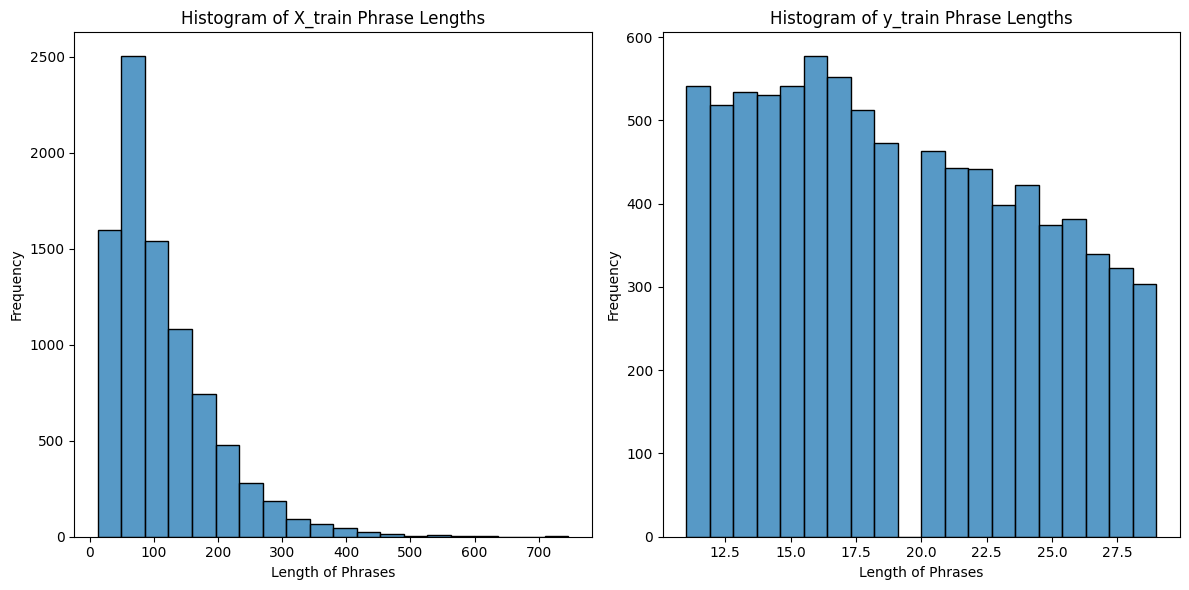

8673 Olivia and Olivier are voting for liberals in this election .
vocabulary size 25644


In [3]:
import seaborn as sns
import matplotlib.pyplot as plt


def load_x_y_train_plain():
    with open('/kaggle/input/summaries-dataset/train.json', 'r', encoding='utf-8') as f:
        try:
            dataset = json.load(f)  # Load the JSON data
        
        except json.JSONDecodeError as e:
            print(f"Error decoding JSON: {e}")
    X_train = []
    y_train = []

    # #Loop through the list and process each dialogue and summary
    for data in dataset:
        dialogue = data['dialogue']  # Split dialogue into a list of lines
        summary = data['summary']

        X_train.append(dialogue)
        y_train.append(summary)
    return X_train,y_train

def split_x_y_train(X_train,y_train):
    X_train=[re.findall(r'\[.*?\]|\w+|[^\w\s]|\n', x) for x in X_train]
    y_train=[re.findall(r'\[.*?\]|\w+|[^\w\s]|\n', y) for y in y_train]
    return X_train,y_train

 
 

# with open('data/vocabolary_full.pkl', 'rb') as f:
#     vocabulary=pickle.load(f)
def filter_train_data(X_train, y_train, to_eliminate):
    filtered_X_train = []
    filtered_y_train = []

    for x, y in zip(X_train, y_train):
        if not any(to_eliminate_str in x for to_eliminate_str in to_eliminate):
            filtered_X_train.append(x)
            filtered_y_train.append(y)
    
    return filtered_X_train, filtered_y_train


def create_complete_vocabulary(X_train, y_train):
    nlp_model = spacy.load('en_core_web_lg')
    nlp_model.disable_pipes(["parser", "ner"])
    complete_text_target = ' '.join(y_train) 
    complete_text_origin = ' '.join(X_train)
    complete_text = complete_text_target + " [START] [PAD] [END] " + complete_text_origin
    
    vocabulary = create_vocabulary(complete_text,"vocabolary_full", nlp_model)
    print("vocabulary size",len(vocabulary))
    return vocabulary


X_train,y_train=load_x_y_train_plain()
to_eliminate=["[I hope I'm not coming off as rude - If I am, I'm sorry. I just thought it would be beneficial for the both of us...]",
    "[pulls back the curtain and checks out the window]",
    "[hopefully, masses of]"]
X_train,y_train = filter_train_data(X_train, y_train, to_eliminate)


sample=np.random.randint(0, len(y_train), size=len(X_train))
sample=[i for i in range(len(y_train))]
min_v=10
max_v=30



X_train=[re.findall(r'\[.*?\]|\w+|[^\w\s]|\n', x) for x in X_train]
y_train=[re.findall(r'\[.*?\]|\w+|[^\w\s]|\n', y) for y in y_train]

X_train=[X_train[i] for i in sample if len(y_train[i])<max_v and len(y_train[i])>min_v]
y_train=[y_train[i] for i in sample if len(y_train[i])<max_v and len(y_train[i])>min_v]


print(len(y_train))

# Calculate lengths of the tokenized phrases
X_lengths = [len(x) for x in X_train]
y_lengths = [len(y) for y in y_train]

# Plot histograms
plt.figure(figsize=(12, 6))

# Histogram for X_train lengths
plt.subplot(1, 2, 1)
sns.histplot(X_lengths, bins=20, kde=False)
plt.title('Histogram of X_train Phrase Lengths')
plt.xlabel('Length of Phrases')
plt.ylabel('Frequency')

# Histogram for y_train lengths
plt.subplot(1, 2, 2)
sns.histplot(y_lengths, bins=20, kde=False)
plt.title('Histogram of y_train Phrase Lengths')
plt.xlabel('Length of Phrases')
plt.ylabel('Frequency')

# Display the plots
plt.tight_layout()
plt.show()
X_train=[" ".join(x) for x in X_train]
y_train=[" ".join(y) for y in y_train]

print(len(y_train),y_train[0])

vocabulary=create_complete_vocabulary(X_train, y_train)

In [7]:

learning_rate=0.001

vocab_size=len(vocabulary)
batch_size=32


#batch_size = len(X_train)
words_per_phrase = num_phrases= max_v+1
dk = dv = embedding_size = 300 # constrain of transformer all embedding size both input embedding and attention embedding are the same encoder
num_heads=5
Qe = cp.random.rand(embedding_size, embedding_size) / cp.sqrt(embedding_size)
Ke = cp.random.rand(embedding_size, embedding_size) / cp.sqrt(embedding_size)
Ve = cp.random.rand(embedding_size, embedding_size) / cp.sqrt(embedding_size)
Qc = cp.random.rand(embedding_size, embedding_size) / cp.sqrt(embedding_size)
Kc = cp.random.rand(embedding_size, embedding_size) / cp.sqrt(embedding_size)
Vc = cp.random.rand(embedding_size, embedding_size) / cp.sqrt(embedding_size)
Qd = cp.random.rand(embedding_size, embedding_size) / cp.sqrt(embedding_size)
Kd = cp.random.rand(embedding_size, embedding_size) / cp.sqrt(embedding_size)
Vd = cp.random.rand(embedding_size, embedding_size) / cp.sqrt(embedding_size)

fl1_size=700
Wfl1e=cp.random.rand(embedding_size, fl1_size)
bfl1e=cp.random.rand(fl1_size)

Wfl2e=cp.random.rand(fl1_size, dv)
bfl2e=cp.random.rand(dv)


Wfl1d=cp.random.rand(embedding_size, fl1_size)
bfl1d=cp.random.rand(fl1_size)

Wfl2d=cp.random.rand(fl1_size, dv)
bfl2d=cp.random.rand(dv)

Wo=cp.random.rand(words_per_phrase*embedding_size,vocab_size)
bo=cp.random.rand(vocab_size)



In [36]:
import traceback

In [ ]:

#X_train,y_train=load_x_y_train_plain()
num_batches_per_epoch = len(X_train) // batch_size
num_epochs=30
learning_rate=0.00001
tot_loss_epoch=0
#num_batches_per_epoch=3
for epoch in range(num_epochs):
    print("Loss per epoch",tot_loss_epoch/num_batches_per_epoch)
    tot_loss_epoch=0
    for i in tqdm(range(0,num_batches_per_epoch),desc=f"Epoch {epoch + 1}/{num_epochs}"):
        try: 
            start = i * batch_size
            end = start + batch_size
            #print("start",start,"end",end)
            X_batch = X_train[start:end]
            y_batch = y_train[start:end]
            #print("start",start,"end",end,i)
            inputs_e=create_input_encoder(X_batch,vocabulary,80,embedding_size)
            #print("inputs_e",inputs_e.shape)
            inputs_d=create_decoder_input(y_batch,embedding_size,words_per_phrase,vocabulary)
            #print("inputs_d",inputs_d.shape)
            #targets_d=create_target(y_batch,words_per_phrase,vocabulary)
            #print("targets_d",targets_d)

            Ae,Attention_weights_e,K_E,V_E,Q_E=forward_attention_encoder(inputs_e)

            Ect1,Xe,mu_e,var_e,Ne=encoder_first_residual_and_norm(Ae,inputs_e) 
            #print("Ecout.shape",Ect1.shape)
            #Ecout,mu_e2,var_e2,N_e2,FLe1,Xe1,Xe2=fully_connected_layers_encoder(Ect1)
            #K_C,V_C=cross_attention_encoder(Ecout)
            K_C,V_C=cross_attention_encoder(Ect1)

            clip_value = 15
            threshold = 15
            #print("K_C.shape",K_C.shape)
            #print("V_C.shape",V_C.shape)
            target_d=pad_sequences(y_batch,lenght=words_per_phrase,target_type="target")
            target_d=[i.split() for i in target_d] 
            tot_loss=0
     
            for step in range(inputs_d.shape[0]):
                inputs_decoder=inputs_d[step]

                target=cp.array([get_one_hot(x[step], vocabulary) for x in target_d])

                A_mask,Attention_weights_masked,Q_D,K_D,V_D=forward_attention_decoder(inputs_decoder)

                Xd,Dt1,mu_d,var_d,N_d=decoder_first_residual_and_norm(A_mask,inputs_decoder)

                Q_C=cross_attention_decoder(Dt1)
                #print("Q_C.shape",Q_C.shape)
                Acr,Attention_weights_cross=cross_attention(Q_C,K_C,V_C,Dt1)

                Dt2, mu_res,var_res,N_res,Res= cross_attention_residual_and_norm(Acr ,Dt1)
                #Dout,mu_d2,var_d2,N_d2,Xd2,Xd1,FLd1=fully_connected_layers_decoder(Dt2)

                Dt2=Dt2.reshape(Dt2.shape[0],Dt2.shape[1]*Dt2.shape[2])
                #print(Dout.shape,Dt2.shape)

                SigmaZout=output_layer(Dt2)

                #print_vocabs(SigmaZout[0:3],vocabulary)

                Loss=loss_calculation(SigmaZout,target)


                tot_loss+=Loss


                #print("step",step,"Loss",Loss)



                #dLoss_Dout,dLoss_W0,dLoss_b0=derivate_dout(SigmaZout,target,Dout)
                dLoss_dZout,dLoss_Dout,dLoss_W0,dLoss_b0=derivate_dout(SigmaZout,target,Dt2)
                #dLoss_Wfl2d,dLoss_bfl2d,dLoss_Wfl1d,dLoss_bfl1d,DLoss_Dt2=derivate_fully_connected_layers_decoder(dLoss_Dout,Dt2,Xd2,var_d2,mu_d2,N_d2,FLd1,Xd1)
                #dLoss_Qc,dLoss_Kc,dLoss_Vc,Attention_weights_cross,dLoss_Dt1_a,dLoss_Acr=derivative_cross_attention(DLoss_Dt2,Res,var_res,mu_res,N_res,Attention_weights_cross,K_C,V_C,Q_C,Ect1,Dt1)
                dLoss_Qc,dLoss_Kc,dLoss_Vc,Attention_weights_cross,dLoss_Dt1_a,dLoss_Acr=derivative_cross_attention(dLoss_Dout,Res,var_res,mu_res,N_res,Attention_weights_cross,K_C,V_C,Q_C,Ect1,Dt1)

                dLoss_Kd,dLoss_Qd,dLoss_Vd,dLoss_inputd_a,dLoss_Amask=derivative_attention_decoder(dLoss_Acr,Attention_weights_cross,dLoss_Dt1_a,Attention_weights_masked,Q_D,V_D,K_D,K_C,V_C,Xd,var_d,mu_d,N_d,inputs_decoder)
                dLoss_inputd,dLoss_dWemb_decoder=derivative_input_decoder(dLoss_Amask,Attention_weights_masked,K_D,V_D,Q_D,dLoss_inputd_a,inputs_decoder)

                all_losses_decoder=[dLoss_dZout,dLoss_Dout,dLoss_W0,dLoss_b0,
                            dLoss_Qc,dLoss_Kc,dLoss_Vc,dLoss_Dt1_a,dLoss_Acr,
                            dLoss_Kd,dLoss_Qd,dLoss_Vd,dLoss_inputd_a,dLoss_Amask,
                            dLoss_inputd,dLoss_dWemb_decoder]
                
                
                
                for idx, loss in enumerate(all_losses_decoder):
                    if loss.any() > threshold:
                        print(f"Element at index {idx} is higher than threshold: {loss}")
                        
                dLoss_W0 = cp.clip(dLoss_W0, -clip_value, clip_value)
                dLoss_b0 = cp.clip(dLoss_b0, -clip_value, clip_value)
                # dLoss_Wfl2d = cp.clip(dLoss_Wfl2d, -clip_value, clip_value)
                # dLoss_bfl2d = cp.clip(dLoss_bfl2d, -clip_value, clip_value)
                # dLoss_Wfl1d = cp.clip(dLoss_Wfl1d, -clip_value, clip_value)
                # dLoss_bfl1d = cp.clip(dLoss_bfl1d, -clip_value, clip_value)

                dLoss_Qc = cp.clip(dLoss_Qc, -clip_value, clip_value)
                dLoss_Kc = cp.clip(dLoss_Kc, -clip_value, clip_value)
                dLoss_Vc = cp.clip(dLoss_Vc, -clip_value, clip_value)
                dLoss_Qd = cp.clip(dLoss_Qd, -clip_value, clip_value)
                dLoss_Kd = cp.clip(dLoss_Kd, -clip_value, clip_value)
                dLoss_Vd = cp.clip(dLoss_Vd, -clip_value, clip_value)
                dLoss_dWemb_decoder = cp.clip(dLoss_dWemb_decoder, -clip_value, clip_value)

                Wo=Wo-learning_rate*dLoss_W0.T
                bo=bo-learning_rate*dLoss_b0
                # Wfl2d=Wfl2d-learning_rate*dLoss_Wfl2d
                # bfl2d=bfl2d-learning_rate*dLoss_bfl2d
                # Wfl1d=Wfl1d-learning_rate*dLoss_Wfl1d
                # bfl1d=bfl1d-learning_rate*dLoss_bfl1d
                Qc=Qc-learning_rate*dLoss_Qc
                Kc=Kc-learning_rate*dLoss_Kc
                Vc=Vc-learning_rate*dLoss_Vc
                Qd=Qd-learning_rate*dLoss_Qd
                Kd=Kd-learning_rate*dLoss_Kd
                Vd=Vd-learning_rate*dLoss_Vd
                inputs_decoder=inputs_decoder-learning_rate*dLoss_dWemb_decoder
                vocabulary=update_wembedding_decoder(y_batch,inputs_decoder,words_per_phrase,vocabulary)


            #print("Loss",tot_loss/inputs_d.shape[0])

            tot_loss_epoch+=tot_loss/inputs_d.shape[0]
#             if (i%50==0):
#                 print("temp tot loss",tot_loss_epoch,i,tot_loss/inputs_d.shape[0])

            dLoss_Ecout=derivative_Ecout(Attention_weights_cross,dLoss_Acr,Q_C,V_C)
            #dLoss_dWfl2e,dLoss_dbfl2e,dLoss_Wfl1e,dLoss_bfl1e,dLoss_Ect1=derivate_fully_connected_layers_encoder(dLoss_Ecout,Ect1,Xe2,var_e2,mu_e2,N_e2,FLe1,Xe1)

            #dLoss_dQe,dLoss_dKe,dLoss_dVe,dLoss_inpute_a,dLoss_Ae=derivative_attention_encoder(dLoss_Ect1,Xe,var_e,mu_e,Ne,Attention_weights_e,K_E,V_E,Q_E,inputs_e)
            dLoss_dQe,dLoss_dKe,dLoss_dVe,dLoss_inpute_a,dLoss_Ae=derivative_attention_encoder(dLoss_Ecout,Xe,var_e,mu_e,Ne,Attention_weights_e,K_E,V_E,Q_E,inputs_e)

            dLoss_inpute,dLoss_dWemb_encoder=derivative_input_encoder(dLoss_Ae,Attention_weights_e,K_E,V_E,Q_E,dLoss_inpute_a,inputs_e)
            
            all_losses_encoder=[dLoss_Ecout,dLoss_dQe,dLoss_dKe,dLoss_dVe,dLoss_inpute_a,dLoss_Ae,
                            dLoss_inpute,dLoss_dWemb_encoder]
                 

           
            for idx, loss in enumerate(all_losses_encoder):
                if loss.any() > threshold:
                    print(f"Element at index {idx} is higher than threshold: {loss}")
            # dLoss_dWfl2e = cp.sum(cp.transpose(dLoss_dWfl2e ,(0,2,1)),axis=0) 
            # dLoss_dWfl2e = cp.clip(dLoss_dWfl2e, -clip_value, clip_value)
            # dLoss_dbfl2e = cp.sum(dLoss_dbfl2e ,axis=0) 
            # dLoss_dbfl2e = cp.clip(dLoss_dbfl2e, -clip_value, clip_value)
            # dLoss_Wfl1e = cp.sum(cp.transpose(dLoss_Wfl1e ,(0,2,1)),axis=0) 
            # dLoss_Wfl1e = cp.clip(dLoss_Wfl1e, -clip_value, clip_value)
            # dLoss_bfl1e = cp.sum(cp.transpose(dLoss_bfl1e ,(0,2,1)),axis=0) 
            # dLoss_bfl1e = cp.clip(dLoss_bfl1e, -clip_value, clip_value)
            dLoss_dQe = cp.clip(dLoss_dQe, -clip_value, clip_value)
            dLoss_dKe = cp.clip(dLoss_dKe, -clip_value, clip_value)
            dLoss_dVe = cp.clip(dLoss_dVe, -clip_value, clip_value)
            dLoss_dWemb_encoder = cp.clip(dLoss_dWemb_encoder, -clip_value, clip_value)
            # Wfl2e=Wfl2e-learning_rate*dLoss_dWfl2e
            # bfl2e=bfl2e-learning_rate*dLoss_dbfl2e
            # Wfl1e=Wfl1e-learning_rate*dLoss_Wfl1e  #print(dLoss_bfl1e.shape,cp.sum(dLoss_bfl1e,axis=0).shape,bfl1e.shape,cp.sum(cp.transpose(dLoss_bfl1e ,(0,2,1)),axis=0).shape)
            # bfl1e=bfl1e-learning_rate*dLoss_bfl1e
            Qe=Qe-learning_rate*dLoss_dQe
            Ke=Ke-learning_rate*dLoss_dKe
            Ve=Ve-learning_rate*dLoss_dVe
            inputs_e=inputs_e-learning_rate*dLoss_dWemb_encoder
            vocabulary=update_wembedding_encoder(X_batch,inputs_e,vocabulary,words_per_phrase)
        except Exception as e:
            print(e)
            traceback.print_exc()
            pass
    #inputs_e=inputs_e-learning_rate*dLoss_dWemb_encoder

Loss per epoch 0.0


Epoch 1/30:  11%|█         | 30/271 [01:27<11:41,  2.91s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_30/1342680679.py", line 20, in <module>
    inputs_d=create_decoder_input(y_batch,embedding_size,words_per_phrase,vocabulary)
  File "/tmp/ipykernel_30/1203802747.py", line 23, in wrapper
    result = func(*args, **kwargs)  # Execute the wrapped function
  File "/tmp/ipykernel_30/1203802747.py", line 290, in create_decoder_input
    yi = cp.array([[vocabulary_decoder[word][0] for word in phrase_vector] for phrase_vector in phrase_vectors_y])
  File "/opt/conda/lib/python3.10/site-packages/cupy/_creation/from_data.py", line 53, in array
    return _core.array(obj, dtype, copy, order, subok, ndmin, blocking)
  File "cupy/_core/core.pyx", line 2408, in cupy._core.core.array
  File "cupy/_core/core.pyx", line 2435, in cupy._core.core.array
  File "cupy/_core/core.pyx", line 2571, in cupy._core.core._array_default
  File "cupy/_core/core.pyx", line 1481, in cupy._core.core._

Implicit conversion to a NumPy array is not allowed. Please use `.get()` to construct a NumPy array explicitly.


Epoch 1/30:  41%|████▏     | 112/271 [05:23<07:41,  2.90s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_30/1342680679.py", line 20, in <module>
    inputs_d=create_decoder_input(y_batch,embedding_size,words_per_phrase,vocabulary)
  File "/tmp/ipykernel_30/1203802747.py", line 23, in wrapper
    result = func(*args, **kwargs)  # Execute the wrapped function
  File "/tmp/ipykernel_30/1203802747.py", line 290, in create_decoder_input
    yi = cp.array([[vocabulary_decoder[word][0] for word in phrase_vector] for phrase_vector in phrase_vectors_y])
  File "/opt/conda/lib/python3.10/site-packages/cupy/_creation/from_data.py", line 53, in array
    return _core.array(obj, dtype, copy, order, subok, ndmin, blocking)
  File "cupy/_core/core.pyx", line 2408, in cupy._core.core.array
  File "cupy/_core/core.pyx", line 2435, in cupy._core.core.array
  File "cupy/_core/core.pyx", line 2571, in cupy._core.core._array_default
  File "cupy/_core/core.pyx", line 1481, in cupy._core.core.

Implicit conversion to a NumPy array is not allowed. Please use `.get()` to construct a NumPy array explicitly.


Epoch 1/30:  59%|█████▊    | 159/271 [07:37<05:26,  2.92s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_30/1342680679.py", line 20, in <module>
    inputs_d=create_decoder_input(y_batch,embedding_size,words_per_phrase,vocabulary)
  File "/tmp/ipykernel_30/1203802747.py", line 23, in wrapper
    result = func(*args, **kwargs)  # Execute the wrapped function
  File "/tmp/ipykernel_30/1203802747.py", line 290, in create_decoder_input
    yi = cp.array([[vocabulary_decoder[word][0] for word in phrase_vector] for phrase_vector in phrase_vectors_y])
  File "/opt/conda/lib/python3.10/site-packages/cupy/_creation/from_data.py", line 53, in array
    return _core.array(obj, dtype, copy, order, subok, ndmin, blocking)
  File "cupy/_core/core.pyx", line 2408, in cupy._core.core.array
  File "cupy/_core/core.pyx", line 2435, in cupy._core.core.array
  File "cupy/_core/core.pyx", line 2571, in cupy._core.core._array_default
  File "cupy/_core/core.pyx", line 1481, in cupy._core.core.

Implicit conversion to a NumPy array is not allowed. Please use `.get()` to construct a NumPy array explicitly.


Epoch 1/30:  77%|███████▋  | 209/271 [09:59<03:00,  2.91s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_30/1342680679.py", line 20, in <module>
    inputs_d=create_decoder_input(y_batch,embedding_size,words_per_phrase,vocabulary)
  File "/tmp/ipykernel_30/1203802747.py", line 23, in wrapper
    result = func(*args, **kwargs)  # Execute the wrapped function
  File "/tmp/ipykernel_30/1203802747.py", line 290, in create_decoder_input
    yi = cp.array([[vocabulary_decoder[word][0] for word in phrase_vector] for phrase_vector in phrase_vectors_y])
  File "/opt/conda/lib/python3.10/site-packages/cupy/_creation/from_data.py", line 53, in array
    return _core.array(obj, dtype, copy, order, subok, ndmin, blocking)
  File "cupy/_core/core.pyx", line 2408, in cupy._core.core.array
  File "cupy/_core/core.pyx", line 2435, in cupy._core.core.array
  File "cupy/_core/core.pyx", line 2571, in cupy._core.core._array_default
  File "cupy/_core/core.pyx", line 1481, in cupy._core.core.

Implicit conversion to a NumPy array is not allowed. Please use `.get()` to construct a NumPy array explicitly.


Epoch 1/30:  83%|████████▎ | 226/271 [10:46<02:10,  2.90s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_30/1342680679.py", line 20, in <module>
    inputs_d=create_decoder_input(y_batch,embedding_size,words_per_phrase,vocabulary)
  File "/tmp/ipykernel_30/1203802747.py", line 23, in wrapper
    result = func(*args, **kwargs)  # Execute the wrapped function
  File "/tmp/ipykernel_30/1203802747.py", line 290, in create_decoder_input
    yi = cp.array([[vocabulary_decoder[word][0] for word in phrase_vector] for phrase_vector in phrase_vectors_y])
  File "/opt/conda/lib/python3.10/site-packages/cupy/_creation/from_data.py", line 53, in array
    return _core.array(obj, dtype, copy, order, subok, ndmin, blocking)
  File "cupy/_core/core.pyx", line 2408, in cupy._core.core.array
  File "cupy/_core/core.pyx", line 2435, in cupy._core.core.array
  File "cupy/_core/core.pyx", line 2571, in cupy._core.core._array_default
  File "cupy/_core/core.pyx", line 1481, in cupy._core.core.

Implicit conversion to a NumPy array is not allowed. Please use `.get()` to construct a NumPy array explicitly.


Epoch 1/30: 100%|██████████| 271/271 [12:54<00:00,  2.86s/it]


Loss per epoch 9.852007011854921


Epoch 2/30:  11%|█         | 30/271 [01:27<11:57,  2.98s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_30/1342680679.py", line 20, in <module>
    inputs_d=create_decoder_input(y_batch,embedding_size,words_per_phrase,vocabulary)
  File "/tmp/ipykernel_30/1203802747.py", line 23, in wrapper
    result = func(*args, **kwargs)  # Execute the wrapped function
  File "/tmp/ipykernel_30/1203802747.py", line 290, in create_decoder_input
    yi = cp.array([[vocabulary_decoder[word][0] for word in phrase_vector] for phrase_vector in phrase_vectors_y])
  File "/opt/conda/lib/python3.10/site-packages/cupy/_creation/from_data.py", line 53, in array
    return _core.array(obj, dtype, copy, order, subok, ndmin, blocking)
  File "cupy/_core/core.pyx", line 2408, in cupy._core.core.array
  File "cupy/_core/core.pyx", line 2435, in cupy._core.core.array
  File "cupy/_core/core.pyx", line 2571, in cupy._core.core._array_default
  File "cupy/_core/core.pyx", line 1481, in cupy._core.core._

Implicit conversion to a NumPy array is not allowed. Please use `.get()` to construct a NumPy array explicitly.


Epoch 2/30:  28%|██▊       | 76/271 [03:38<09:26,  2.91s/it]